# Convolutional Neural Networks (CNNs) and Transfer learning - D7046E @ LTU.SE

# Introduction

This third and last ANN exercise includes two parts: the first part is an introduction to CNNs and transfer learning, and the second part introduces the **ANN project**. During the third course week you should familiarise yourself with the second part describing the project, so that you can select if you want to perform the ANN *or* SNN project. After completing ANN 2, all students should complete this exercise.

The goal of this exercise is to understand what convolution is and how convolution is used in artificial neural networks that can benefit from translation invariance in some of the input dimensions, for example in image and sound processing. The exercise will also teach you about transfer learning, fine-tuning and feature extraction.

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined below to 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements described below prepared before presenting.**

### Task 1
1. Implementation of "same convolution".
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

In [1]:
%matplotlib inline

In [2]:
epochs = 30

# Understanding Convolutional Neural Networks (CNNs)

Before diving into the implementation, it's crucial to develop an intuitive understanding of how CNNs work and why they're so effective for image-related tasks.

## Visual and Interactive Resources

To develop your intuition for CNNs, we strongly recommend exploring these interactive visualizations and animations:

- **[CNN Explainer](https://poloclub.github.io/cnn-explainer/)** - An interactive visualization that lets you see how CNNs process images in real-time. You can upload your own images and watch activations propagate through the network.
- **[ConvNetJS CIFAR-10 Demo](https://cs.stanford.edu/people/karpathy/convnetjs/demo/cifar10.html)** - Watch a CNN train in your browser and see how filters evolve during training.
- **[3Blue1Brown: Convolutional Neural Networks](https://www.youtube.com/watch?v=KuXjwB4LzSA)** - Visual breakdown of convolution operations.
- **[Convolution Arithmetic](https://github.com/vdumoulin/conv_arithmetic)** - Animated GIFs showing different convolution operations (padding, strides, dilations).

## Key Concepts: Why CNNs Work

### 1. **Local Connectivity & Parameter Sharing**
Traditional fully-connected layers would require millions of parameters for even small images (e.g., a 224×224 RGB image = 150,528 input features). CNNs solve this by:
- **Local receptive fields**: Each neuron only looks at a small patch of the image
- **Weight sharing**: The same filter (kernel) slides across the entire image, dramatically reducing parameters
- **Translation invariance**: A feature detector works anywhere in the image

### 2. **Hierarchical Feature Learning**
CNNs automatically learn a hierarchy of features:
```
Early layers → Simple features (edges, colors, textures)
Middle layers → Patterns (corners, shapes, simple objects)
Deep layers → Complex features (eyes, wheels, faces)
Output layer → High-level concepts (dog, car, airplane)
```

### 3. **The Convolution Operation**
When a filter (kernel) slides over an image:
- It performs element-wise multiplication with the local patch
- Sums the results to produce one output value
- This detects specific patterns (like edges, corners, textures)
- Different filters detect different features

**Visualizing a 3×3 filter sliding over an image:**
```
Input:          Kernel:        Output:
[1 2 3 4 5]     [1 0 1]       [13 16 19]
[2 3 4 5 6]  ⊛  [0 1 0]   →   [18 21 24]
[3 4 5 6 7]     [1 0 1]       [23 26 29]
```

The term "same convolution" refers to a type of convolution operation used in CNNs where padding (typically zeros) is added to the input data such that the output feature map retains the same spatial dimensions (height and width). The term "convolution" in CNNs is a common convention, but it differs from the strict mathematical definition. Formally, the mathematical convolution operator used in transform theory (e.g., Fourier transforms) involves reversing one of the signals, typically the kernel, before the element-wise multiplication and summation. By contrast, the "convolution" operator used in CNNs do not reverse the kernel and actually performs a so-called cross-correlation operation. This simplifies computation and backpropagation in deep learning frameworks like TensorFlow and PyTorch.

### 4. **What Do Filters Actually Learn?**
- **Layer 1**: Edge detectors (horizontal, vertical, diagonal), color blobs
- **Layer 2**: Textures, simple shapes, corners
- **Layer 3**: Object parts (wheels, eyes, windows)
- **Layer 4+**: Full objects and complex patterns

You can explore learned filters at: [Distill.pub - Feature Visualization](https://distill.pub/2017/feature-visualization/)

## Additional References

For deeper understanding, consult these resources:

- **[Deep Learning Book - Chapter 9](https://www.deeplearningbook.org/)** - Convolutional Networks (comprehensive theoretical foundation)
- **[CS231n Stanford Course](http://cs231n.stanford.edu/)** - Convolutional Neural Networks for Visual Recognition
- **[Distill.pub](https://distill.pub/)** - High-quality, visual explanations of deep learning concepts
- **[Understanding Convolutions](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/)** - Mathematical perspective with clear examples
- **[A guide to convolution arithmetic](https://arxiv.org/abs/1603.07285)** - Technical deep dive into convolution mathematics

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

[[False False False False]
 [False False False False]
 [False False False False]
 [False False False False]]


TypeError: Image data of dtype object cannot be converted to float

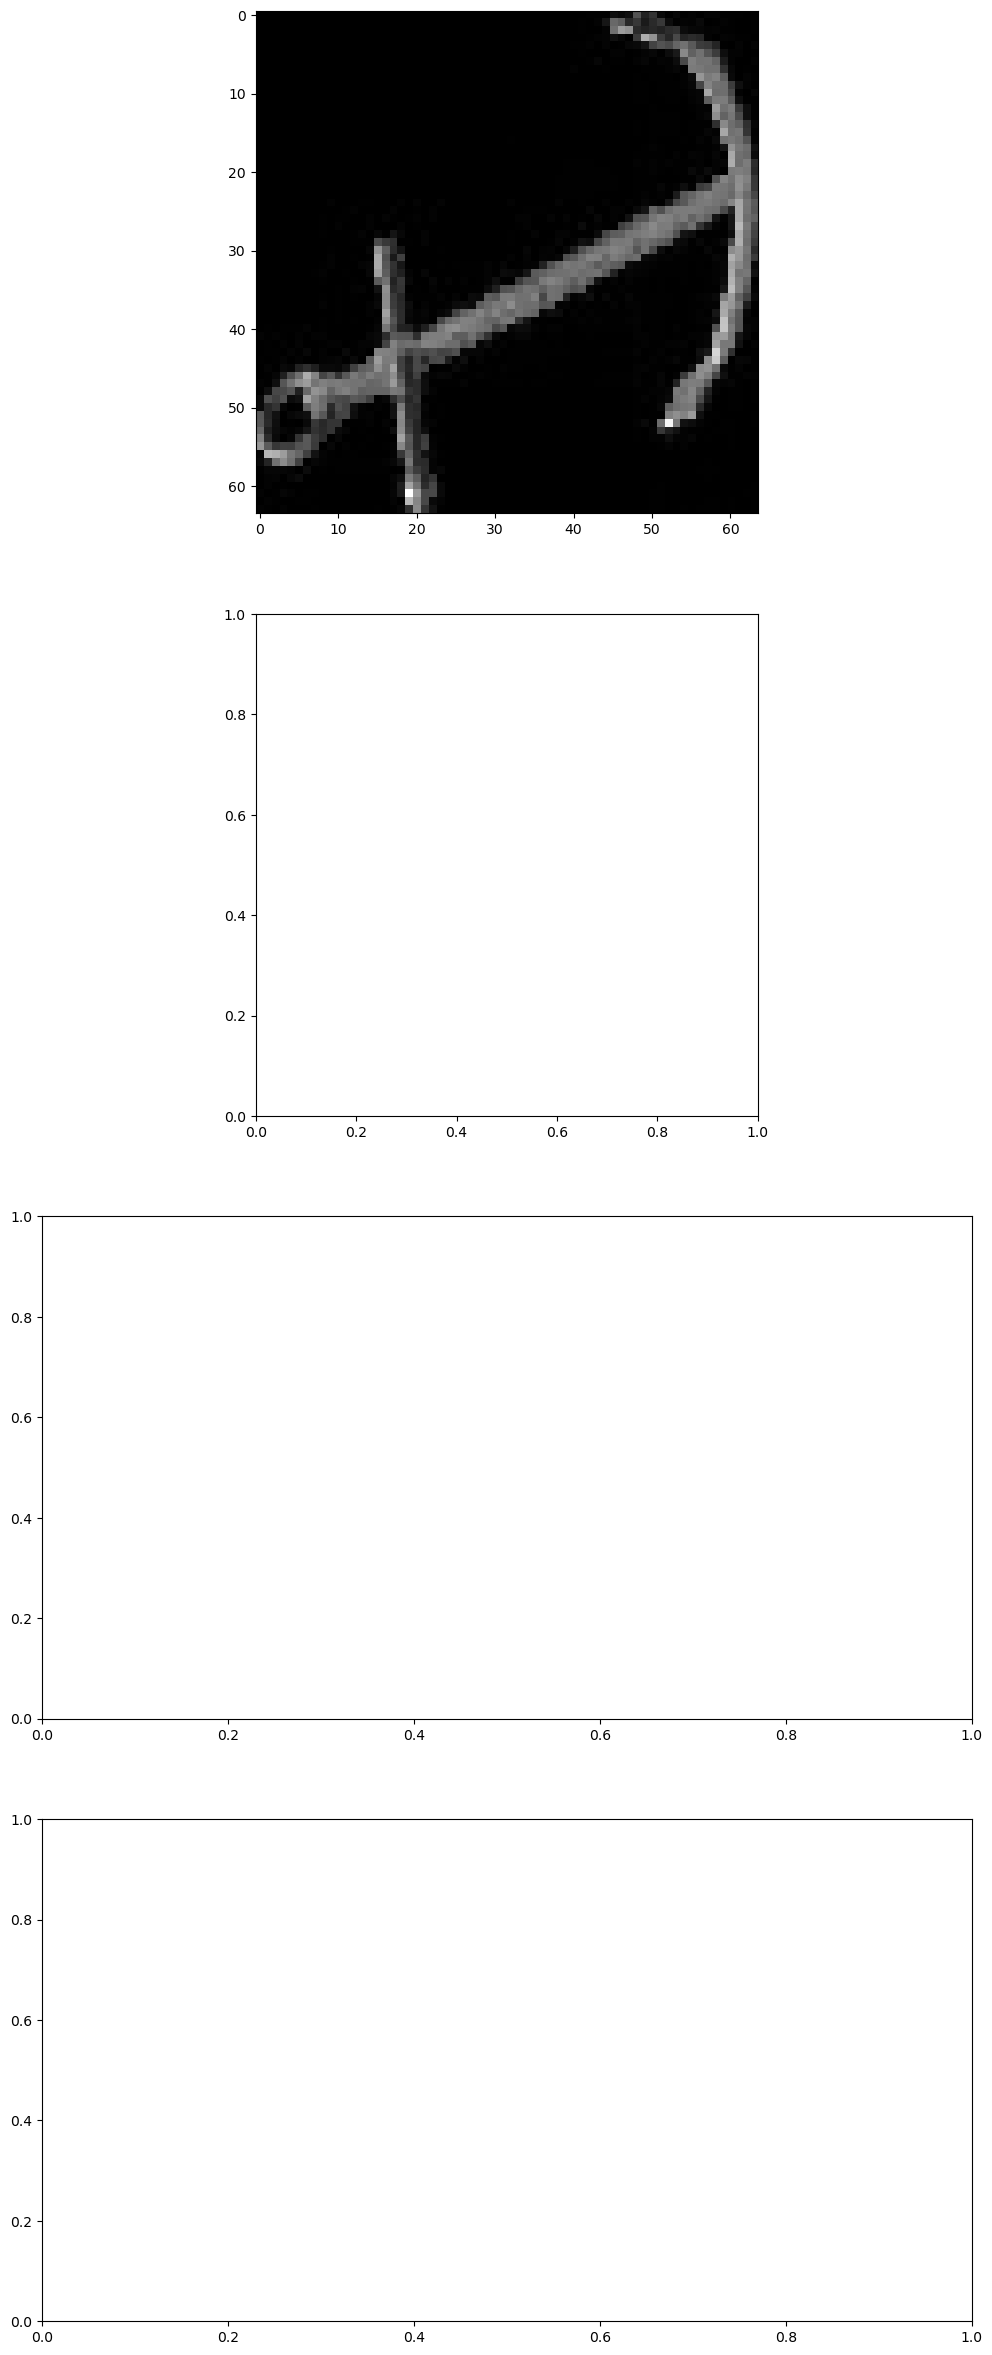

In [ ]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

# Implement same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)
def conv(image, kernel, strides=1): #____________________________ Solving problem here neded <----------------------------------
    pass

# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(conv(inp, kernel) == ans)

f, axarr = plt.subplots(4,1)

# How to load images using opencv
image_path = r"C:\Users\david\Desktop\ANNTHREE\ANN3_dataset\101_ObjectCategories_2classes\anchor\image_0001.jpg" # add your file path here
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray scale so we dont have to deal with more than 1 channel

# Define your 3 kernels
kernel_1 = np.array([#Vertikal Kant
    [-1, 0, 1], #Förklara matematiska sambandet   <-------------------------------
    [-2, 0, 2],
    [-1, 0, 1]
])   
kernel_2 = np.array([#Horisontell Kant
    [-1, -2, -1], #Förklara matematiska sambandet   <-------------------------------
    [ 0,  0,  0],
    [ 1,  2,  1]
])   
kernel_3 = np.array([#Diagonal Kant
    [2, 1, 0], #Förklara matematiska sambandet   <-------------------------------
    [1, 0,-1],
    [0,-1,-2]
])

   

# Perform the convolution (might take a couple of seconds depending on the implementation)
output1 = conv(image, kernel_1) # <---------- Output error from conv
output2 = conv(image, kernel_2)
output3 = conv(image, kernel_3)

# plot the loaded image and the 3 convoluted images
axarr[0].imshow(image, cmap="gray")
axarr[1].imshow(output1, cmap="gray")
axarr[2].imshow(output2, cmap="gray")
axarr[3].imshow(output3, cmap="gray")

plt.show()

# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset that you should use for this exercise can be downloaded in Canvas**. It is a subset of [this dataset](https://data.caltech.edu/records/mzrjq-6wc02). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        # Implement the forward function in the network
        pass

# Implement a train model function so you can re_use it in task 3 and 4. 
# Should return the best performing model after training
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    pass


# Hyperparams. Set these to reasonable values
BATCH_SIZE = ...
SHUFFLE = ...
LEARNING_RATE = ...

# Train augmentations
transforms = transforms.Compose([
    # Add training augmentations here, remember: we do not want to transform the validation images.
    # For information about augmentation see: https://pytorch.org/vision/stable/transforms.html
])

# Load the full dataset, perform the training/validation/test split and then load the subsets into dataloaders.
# Remember that the training images should be augmentated.
DATA_DIR = "" # Path to dataset

train_loader = ...
val_loader = ...

# Load our network
model = Net()

# Define our loss function
criterion = ....

# Define our optimizer
optimizer = ....

# Train the model
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

# Test the model
tested_model = ....

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should fine-tune Resnet18 to the small dataset which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

In [ ]:
# Fine-tune a model to the dataset
# We use resnet18 as the model.
model_ft = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model

# Train the model
trained_model_ft = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader, epochs)

# Test the model
tested_model = ....

## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

In [ ]:
# Use a predefined model as a feature extractor

# We use resnet18 as the model.
model_fe = models.resnet18(pretrained=True)

# Do the things required for fine-tuning before training the model

# Train the model
trained_model_fe = train_model(model_fe, criterion_fe, optimizer_fe, train_loader, val_loader, epochs)

# Test the model
tested_model = ....

# ANN Project: Audio Classification with CNN and RNN

## Project Overview

For students who select the ANN project track, the goal is to classify audio commands from the **Google Speech Commands dataset** using both Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN), and compare their robustness to varying levels of background "noise" sampled from another dataset.

## Datasets

### Google Speech Commands Dataset
The [Google Speech Commands dataset](https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html) is a collection of short (1 second) audio clips of spoken words. The dataset contains 65,000 utterances of 30 short words by thousands of different speakers. Each audio file is sampled at 16 kHz.

**Dataset characteristics:**
- Sample rate: 16 kHz
- Duration: 1 second per clip
- Number of classes: 30 words (e.g., "yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", etc.)
- Total samples: ~65,000

**How to access:** The dataset can be loaded directly using `torchaudio.datasets.SPEECHCOMMANDS` or downloaded from the [official repository](http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz).

### ESC-50: Environmental Sound Classification
The [ESC-50 dataset](https://github.com/karolpiczak/ESC-50) contains 2,000 environmental audio recordings organized into 50 classes (40 clips per class). For this project, you will use sounds from this dataset as background noise to test the robustness of your models.

**Dataset characteristics:**
- Sample rate: 44.1 kHz (needs resampling to 16 kHz before combining with a speech command)
- Duration: 5 seconds per clip
- Categories include: rain, sea waves, crackling fire, clock tick, dog bark, footsteps, door knock, etc.

**How to access:** Download from the [ESC-50 GitHub repository](https://github.com/karolpiczak/ESC-50).

## Project Task

### Objective
Compare the performance of CNN and RNN architectures for speech command classification under different levels of background noise. The models should have a similar number of trainable parameters to ensure a fair comparison.

### Requirements

#### 1. Data Preprocessing
- **Resample** the ESC-50 background sounds from 44.1 kHz to **16 kHz** to match the Google Speech Commands sample rate
- Create augmented versions of the Speech Commands dataset by mixing in background noise at different signal-to-noise ratios

#### 2. Noise Mixing
Evaluate classification accuracy on the Speech Commands dataset with **three noise levels** based on signal RMS (Root Mean Square):

- **0% noise:** Clean speech commands audio (no background noise added)
- **10% noise:** RMS of background noise = 10% of speech command RMS
- **50% noise:** RMS of background noise = 50% of speech command RMS (i.e., equal signal and noise power)

The RMS mixing ensures consistent and measurable noise levels across all experiments.

#### 3. Model Implementation
Implement and train two model architectures:

**a) Convolutional Neural Network (CNN)**
- Process audio spectrograms (e.g., Mel-spectrograms, MFCCs) as 2D images
- Use convolutional layers to extract features from time-frequency representations

**b) Recurrent Neural Network (RNN)**
- Process raw audio waveforms or frame-based features sequentially
- Use LSTM or GRU layers to capture temporal dependencies

**Important:** Both models should have approximately the same number of parameters for a fair comparison.

#### 4. Performance Metrics
For each model and noise level, report:
- Training accuracy
- Validation accuracy
- Test accuracy
- Confusion matrix

#### 5. Minimum Accuracy Requirement
Your models should achieve **at least 75% test accuracy** on the clean (0% noise) Speech Commands dataset. This ensures that your baseline model is working correctly before evaluating noise robustness.

#### 6. Analysis
Compare and discuss:
- Which architecture (CNN or RNN) performs better at each noise level?
- How does performance degrade as noise increases?
- What are the computational trade-offs between the two approaches?
- Which types of commands are most/least robust to noise?


### Optional challenge (deepening)
Can you combine CNN and RNN to make one model that performs better in terms of accuracy versus total parameter count? Which type of model performs best at very high noise level? What level of noise is too high for reliable classification?

## Key Resources

### PyTorch Documentation
- **[torchaudio.datasets.SPEECHCOMMANDS](https://pytorch.org/audio/stable/generated/torchaudio.datasets.SPEECHCOMMANDS.html)** - Official documentation for loading the Speech Commands dataset
- **[torchaudio.transforms](https://pytorch.org/audio/stable/transforms.html)** - Audio transformations including MelSpectrogram, MFCC, and Resample
- **[PyTorch LSTM Documentation](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)** - For implementing RNN models
- **[PyTorch Conv2d Documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)** - For implementing CNN models

### Useful Libraries
- **torchaudio**: For audio loading, transformations (Mel-spectrogram, MFCC, resampling), and the SPEECHCOMMANDS dataset
- **torch.nn**: For building CNN (Conv2d, MaxPool2d) and RNN (LSTM, GRU) architectures
- **librosa**: Alternative library for audio feature extraction and processing
- **numpy**: For signal processing, RMS calculations, and noise mixing

## Getting Started

1. **Load the datasets**: Use `torchaudio.datasets.SPEECHCOMMANDS` for speech commands and download ESC-50 from GitHub
2. **Explore the data**: Understand audio formats, sample rates, and class distributions
3. **Implement preprocessing**: Create a pipeline for resampling ESC-50 sounds and mixing noise at different RMS levels
4. **Design CNN architecture**: Start with a model that processes Mel-spectrograms or MFCCs as 2D images
5. **Design RNN architecture**: Build an LSTM/GRU model with similar parameter count that processes sequential audio features
6. **Train on clean data**: Ensure both models achieve at least 75% accuracy before adding noise
7. **Evaluate on noisy data**: Test both models on 10% and 50% noise levels
8. **Analyze and compare**: Create plots and confusion matrices to compare model performance

## Submission

Your project submission should include:
- Complete Jupyter notebook with all code, visualizations, and analysis
- Clear documentation of your model architectures (number of parameters for each)
- Performance comparison plots (accuracy vs. noise level for both models)
- Confusion matrices for at least the 0%, 10% and 50% noise conditions
- Discussion of results and conclusions